# More than one type of cluster

We can and often should use more than one type of cluster in the same model. For example, the observations in data(chimpanzees), are lever pulls. Each pull is within a cluster of pulls belonging to an individual chimpanzee. But each pull is also an experimental block, which represents a collection of observations that happened on the same day.

So in this section, we'll consider the chimpanzees data, using both types of clusters simulataneously. This will allow partial pooling on both categorical variables, actor and block at the same time. We'll also get estimates of the variation among actors and among blocks.


## Multilevel chimpanzees

Lets proceed by taking the chimpanzees model from chapter 11 and add varying intercepts. To ad varying intercepts to this model we just replace the fixed regularising prior with an adaptive prior. We'll also add a second cluster type. To add the second cluster type - block (which day the experiment has conducted) - we merely replicate the structure for the 'actor' cluster. This means the linear model gets yet another varying intercept alpha_block, and the model gets another adaptive prior and yet another standard deviation parameter

L = Binomial(1,p)

logit(p) = alpha_actor + gamma_block + beta_treatment

beta = Normal(0,0.5)

alpha = Normal(alpha_bar, sigma_alpha)

gamma = Normal(0, sigma_gamma)

alpha_bar = Normal(0,1.5)

sigma_alpha = Exponential(1)

sigma_gamma = Exponential(1)

Each cluster gets its own vector of parameters. For actors, the vector is alpha, and it has length 7, because there are 7 chimpanzees in th same. For blocks, the vector is gamma, annd it has length 6, because there are 6 blocks. Each cluster variable needs its own standard deviation parameter that adapts the amound of pooling across units, be they actors or blocks. Finally note that there is only one global mean parameter alpha_bar. We can't indentigy a seperate mean for each varying intercept type, because  both intercepts are added to the same linear prediction. 

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from scipy import stats
from scipy.special import expit as logistic

In [4]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.credible_interval"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

In [9]:
d = pd.read_csv("chimpanzees.csv", sep=";")

In [15]:
treatment = (d.prosoc_left + 2 * d.condition).values
Ntreatments = len(np.unique(treatment))

actor = (d.actor - 1).astype(int).values
Nactor = len(np.unique(actor))

block = (d.block - 1).astype(int).values
Nblock = len(np.unique(block))

In [16]:
Ntreatments

4

In [17]:
with pm.Model() as m_13_4:
    # hyper-priors
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_g = pm.Exponential("sigma_g", 1.0)

    # adaptive priors
    a = pm.Normal("a", a_bar, sigma_a, shape=Nactor)  # 7 chimps
    g = pm.Normal("g", 0.0, sigma_g, shape=Nblock)   # 6 blocks (days)

    b = pm.Normal("b", 0.0, 0.5, shape=Ntreatments) # 4 treatments (L/R Pro/NoPro)
    
    #logit model
    p = pm.math.invlogit(a[actor] + g[block] + b[treatment])
    
    # Binomial likelihood
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_13_4 = pm.sample(tune=3000, target_accept=0.95, random_seed=RANDOM_SEED)
    idata_13_4 = az.from_pymc3(trace_13_4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, g, a, sigma_g, sigma_a, a_bar]
Sampling 4 chains, 5 divergences: 100%|██████████| 14000/14000 [00:32<00:00, 425.08draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8550950740829611, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


The model actually did sample fine. But these warnings indicate that it had some trouble efficeintly exploring the posterior. In the next section, I'll show you how to fix this. For now we can keep moving and interpret the posterior

In [18]:
az.summary(idata_13_4, round_to=2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,0.58,0.72,-0.80,1.90,0.02,0.02,1024.90,1024.90,1015.47,1034.99,1.00
a[0],4.70,1.37,2.55,7.17,0.05,0.03,881.49,767.87,1058.86,904.64,1.00
a[1],-0.68,0.36,-1.36,-0.01,0.02,0.01,472.15,472.15,468.34,1096.95,1.02
a[2],-0.68,0.36,-1.35,0.00,0.02,0.01,498.34,498.34,498.81,922.20,1.02
a[3],-0.38,0.35,-1.01,0.31,0.02,0.01,515.75,515.75,512.35,1010.09,1.02
a[4],0.56,0.36,-0.04,1.31,0.02,0.01,336.97,336.97,331.74,1046.62,1.02
a[5],2.07,0.45,1.14,2.84,0.02,0.01,656.49,656.49,652.12,1012.56,1.01
a[6],-0.36,0.36,-1.06,0.26,0.02,0.01,446.52,446.52,456.75,929.72,1.02
g[0],0.04,0.17,-0.28,0.41,0.01,0.01,915.81,547.51,1053.85,633.56,1.02
g[1],0.05,0.17,-0.24,0.42,0.01,0.00,819.41,615.23,973.03,797.99,1.03


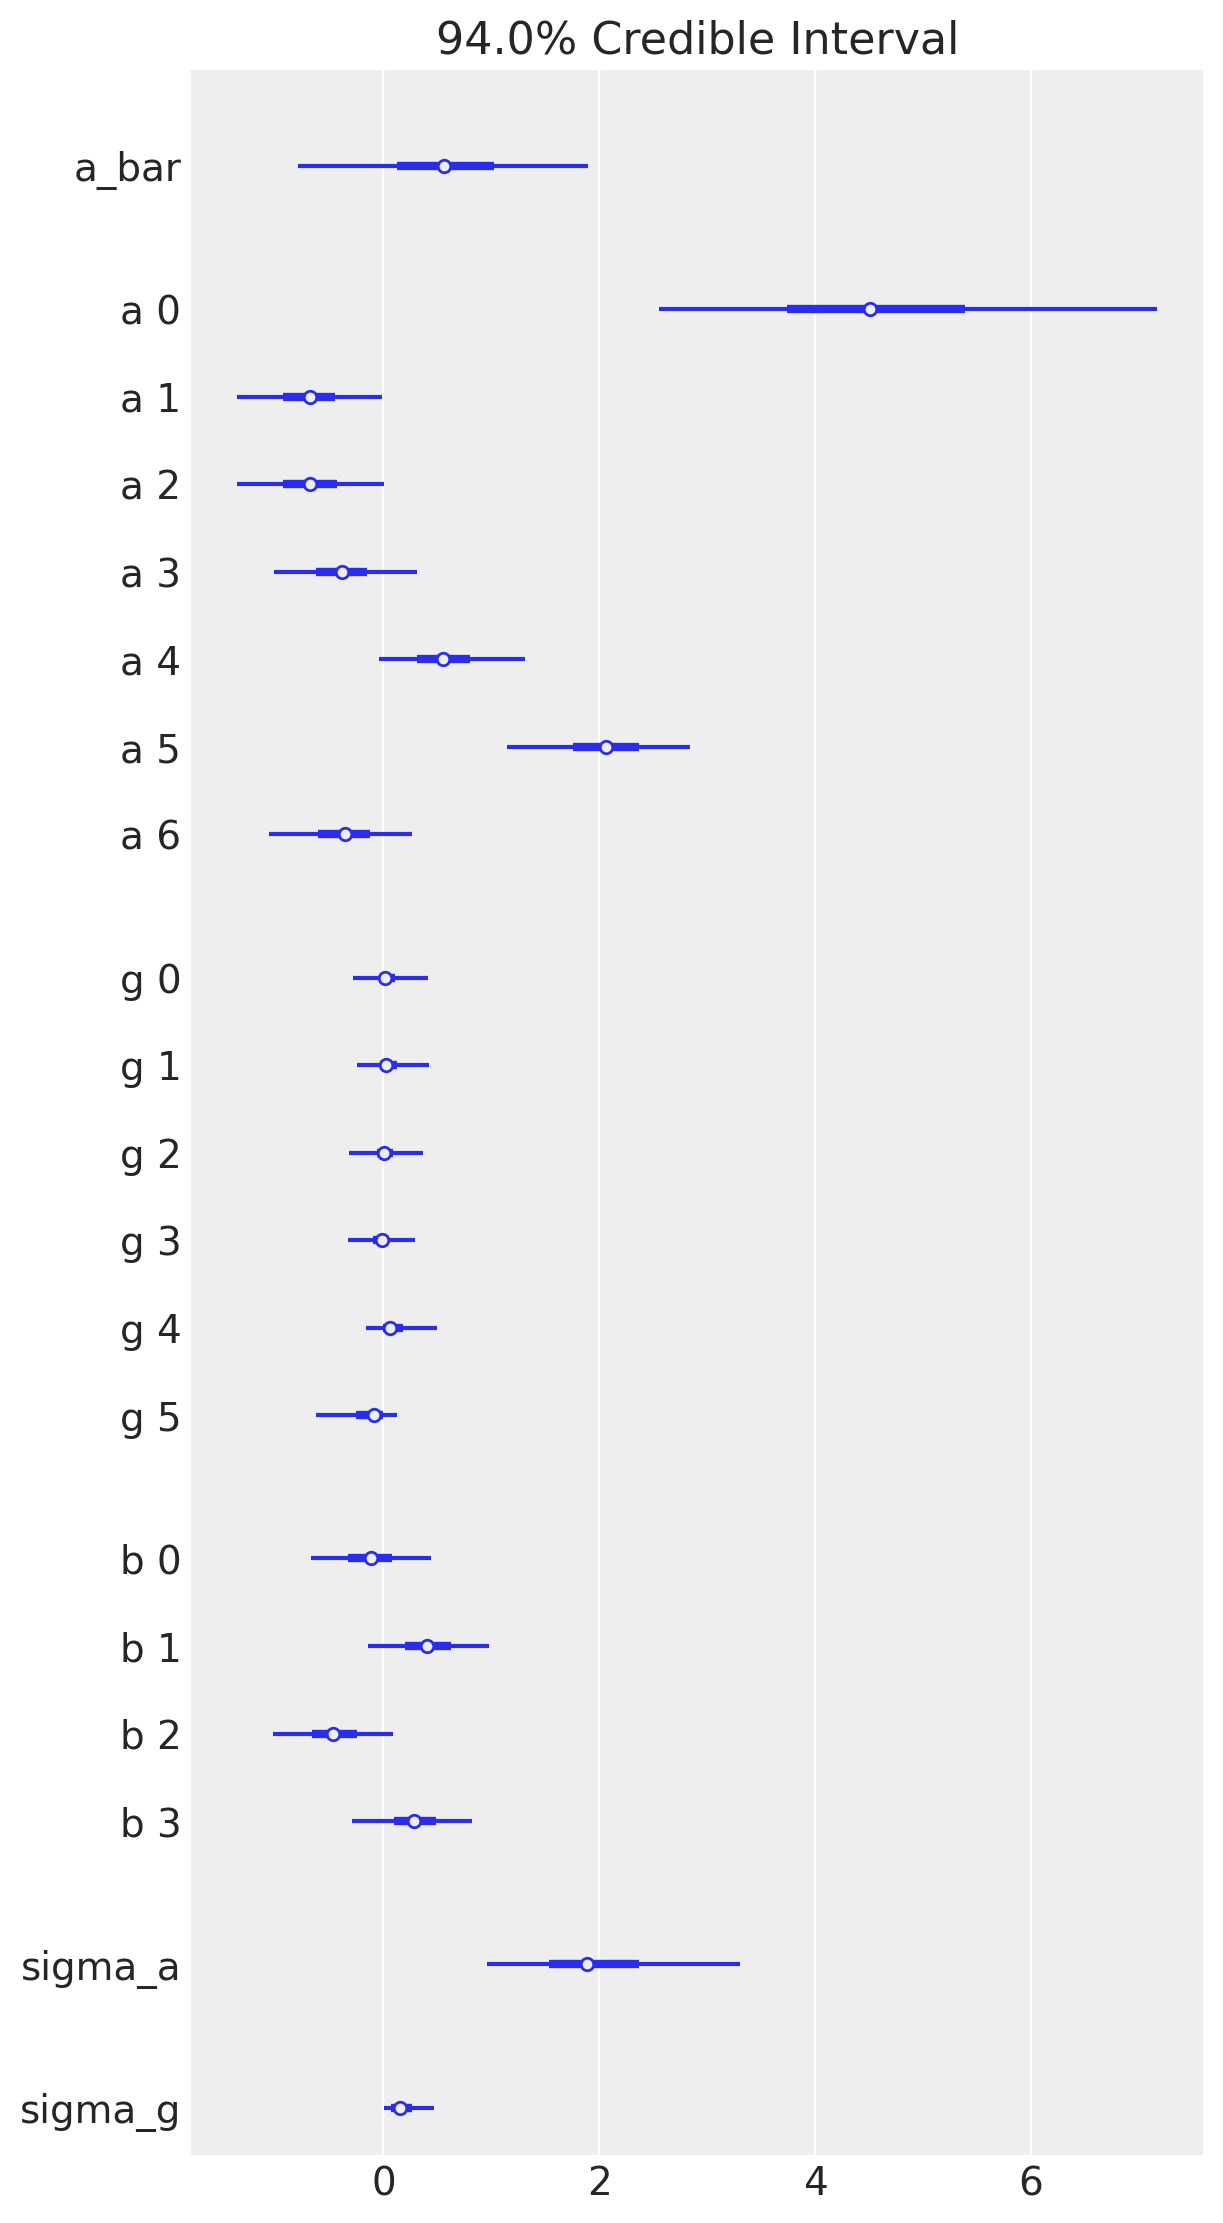

In [19]:
az.plot_forest(idata_13_4, combined=True);